# Phase 3 — XGBoost Fraud Detection Model
**Inputs:** `X_train_fe.csv`, `y_train_fe.csv` (Phase 2) · `X_test.csv`, `y_test.csv` (Phase 1)  
**Goal:** Baseline Logistic Regression → XGBoost → Evaluation → Cost analysis → SHAP  
**Constraints:** No SMOTE · No random split · No leakage · No hyperparameter search

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")

# ── Load engineered training data (Phase 2 outputs) ───────────────────────────
X_train_fe = pd.read_csv("data/processed/X_train_fe.csv")
y_train_fe = pd.read_csv("data/processed/y_train_fe.csv")

# ── Load raw test data (Phase 1 outputs) ──────────────────────────────────────
X_test_raw = pd.read_csv("data/processed/X_test.csv")
y_test      = pd.read_csv("data/processed/y_test.csv")

# ── Load train-only scaling params (from Phase 2) ────────────────────────────
scaling_params = pd.read_csv("data/processed/train_scaling_params.csv").iloc[0]
MEAN_AMOUNT = scaling_params["mean_amount"]
STD_AMOUNT  = scaling_params["std_amount"]

print("Training data (engineered):")
print(f"  X_train_fe : {X_train_fe.shape}  |  fraud rate: {y_train_fe['Class'].mean()*100:.4f}%")
print(f"\nTest data (raw, pre-engineering):")
print(f"  X_test_raw : {X_test_raw.shape}  |  fraud rate: {y_test['Class'].mean()*100:.4f}%")
print(f"\nScaling constants (train-only):  mean={MEAN_AMOUNT:.4f}  std={STD_AMOUNT:.4f}")
print(f"\nEngineered feature columns ({X_train_fe.shape[1]}):")
print(list(X_train_fe.columns))

Training data (engineered):
  X_train_fe : (227843, 39)  |  fraud rate: 0.1830%

Test data (raw, pre-engineering):
  X_test_raw : (56962, 30)  |  fraud rate: 0.1317%

Scaling constants (train-only):  mean=90.8249  std=250.5032

Engineered feature columns (39):
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'log_amount', 'amount_zscore_global', 'rolling_mean_amount', 'rolling_std_amount', 'time_diff', 'amount_deviation', 'amount_zscore_rolling', 'rolling_fraud_count_500', 'rolling_fraud_rate_500']


## Step 1 — Apply Feature Engineering to Test Set

The identical transformation pipeline from Phase 2 is applied to the test set.

**Leakage rules enforced:**
- Amount normalisation uses `mean_amount` / `std_amount` from **train only** (loaded above).
- Rolling windows on the test set use only past test rows (`.shift(1)` before `.rolling()`).
- The test set is never mixed with training data.
- NaN rows from rolling cold-start are dropped.

In [2]:
def apply_feature_pipeline(df_raw: pd.DataFrame, y_raw: pd.DataFrame,
                            mean_amount: float, std_amount: float,
                            window_amount: int = 100,
                            window_fraud: int = 500) -> tuple:
    """
    Apply the Phase 2 feature engineering pipeline to an arbitrary split
    (train or test) without leaking any information across splits.

    Parameters
    ----------
    df_raw       : feature-only DataFrame sorted by Time, no Class column.
    y_raw        : aligned Series / single-column DataFrame with Class.
    mean_amount  : train-only mean for global z-score (do NOT recompute).
    std_amount   : train-only std  for global z-score.

    Returns
    -------
    X_fe, y_fe   : NaN-dropped, aligned feature matrix and target.
    """
    df = df_raw.copy()
    df["Class"] = y_raw["Class"].values

    # Ensure chronological order (test set was sorted by Time in Phase 1)
    df = df.sort_values("Time").reset_index(drop=True)

    # ── Step 1: Basic transforms ─────────────────────────────────────────────
    df["log_amount"]          = np.log1p(df["Amount"])
    df["amount_zscore_global"] = (df["Amount"] - mean_amount) / std_amount

    # ── Step 2: Rolling behavioural features (past-only via shift) ───────────
    amount_shifted = df["Amount"].shift(1)
    df["rolling_mean_amount"] = amount_shifted.rolling(window_amount, min_periods=1).mean()
    df["rolling_std_amount"]  = amount_shifted.rolling(window_amount, min_periods=2).std(ddof=1)
    df["time_diff"]           = df["Time"] - df["Time"].shift(1)

    # ── Step 3: Deviation features ───────────────────────────────────────────
    df["amount_deviation"]     = df["Amount"] - df["rolling_mean_amount"]
    std_safe                   = df["rolling_std_amount"].replace(0, np.nan)
    df["amount_zscore_rolling"] = df["amount_deviation"] / std_safe

    # ── Step 4: Fraud momentum (shift Class to avoid current-row leakage) ────
    class_shifted = df["Class"].shift(1)
    df["rolling_fraud_count_500"] = class_shifted.rolling(window_fraud, min_periods=1).sum()
    df["rolling_fraud_rate_500"]  = class_shifted.rolling(window_fraud, min_periods=1).mean()

    # ── Step 5: Drop NaN rows (cold-start only, no fill) ─────────────────────
    ENGINEERED_COLS = [
        "log_amount", "amount_zscore_global",
        "rolling_mean_amount", "rolling_std_amount", "time_diff",
        "amount_deviation", "amount_zscore_rolling",
        "rolling_fraud_count_500", "rolling_fraud_rate_500",
    ]
    original_cols = [c for c in df_raw.columns]
    all_feat_cols = original_cols + ENGINEERED_COLS

    feature_df = df[all_feat_cols + ["Class"]].dropna().reset_index(drop=True)

    X_fe = feature_df[all_feat_cols]
    y_fe = feature_df[["Class"]]
    return X_fe, y_fe


# ── Apply to test set ─────────────────────────────────────────────────────────
X_test_fe, y_test_fe = apply_feature_pipeline(
    X_test_raw, y_test,
    mean_amount=MEAN_AMOUNT, std_amount=STD_AMOUNT
)

# ── Align columns exactly to train (same order, same set) ────────────────────
FEATURE_COLS = list(X_train_fe.columns)
X_test_fe = X_test_fe[FEATURE_COLS]   # reorder / subset to match train exactly

print(f"X_train_fe : {X_train_fe.shape}  |  fraud rate: {y_train_fe['Class'].mean()*100:.4f}%")
print(f"X_test_fe  : {X_test_fe.shape}   |  fraud rate: {y_test_fe['Class'].mean()*100:.4f}%")
print(f"\nColumn alignment check — sets equal: {set(X_train_fe.columns) == set(X_test_fe.columns)}")
print(f"Column ordering identical          : {list(X_train_fe.columns) == list(X_test_fe.columns)}")

X_train_fe : (227843, 39)  |  fraud rate: 0.1830%
X_test_fe  : (56960, 39)   |  fraud rate: 0.1317%

Column alignment check — sets equal: True
Column ordering identical          : True


## Step 2 — Baseline Logistic Regression

`class_weight="balanced"` compensates for the severe class imbalance (~0.17% fraud) without SMOTE.  
StandardScaler is applied **inside** the pipeline so the test set is transformed using train statistics only — no leakage.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support, confusion_matrix,
    roc_curve, precision_recall_curve
)

# ── Build pipeline: scale then classify ───────────────────────────────────────
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=42,
        solver="lbfgs",
        n_jobs=-1
    ))
])

y_tr = y_train_fe["Class"].values
y_te = y_test_fe["Class"].values

print("Training Logistic Regression …")
lr_pipeline.fit(X_train_fe, y_tr)
print("Done.")

# ── Probabilities and predictions ─────────────────────────────────────────────
lr_proba = lr_pipeline.predict_proba(X_test_fe)[:, 1]
lr_pred  = lr_pipeline.predict(X_test_fe)

# ── Metrics ───────────────────────────────────────────────────────────────────
lr_roc_auc = roc_auc_score(y_te, lr_proba)
lr_pr_auc  = average_precision_score(y_te, lr_proba)
prec, rec, f1, _ = precision_recall_fscore_support(y_te, lr_pred, pos_label=1, average="binary")
cm_lr = confusion_matrix(y_te, lr_pred)

tn, fp_lr, fn_lr, tp = cm_lr.ravel()

print(f"\nLogistic Regression — Test Set Metrics")
print(f"{'─'*40}")
print(f"  ROC-AUC   : {lr_roc_auc:.4f}")
print(f"  PR-AUC    : {lr_pr_auc:.4f}")
print(f"  Recall    : {rec:.4f}")
print(f"  Precision : {prec:.4f}")
print(f"  F1-score  : {f1:.4f}")
print(f"\nConfusion Matrix:")
print(f"  TN={tn:,}  FP={fp_lr:,}")
print(f"  FN={fn_lr:,}  TP={tp:,}")

Training Logistic Regression …
Done.

Logistic Regression — Test Set Metrics
────────────────────────────────────────
  ROC-AUC   : 0.9861
  PR-AUC    : 0.7597
  Recall    : 0.9067
  Precision : 0.0554
  F1-score  : 0.1045

Confusion Matrix:
  TN=55,726  FP=1,159
  FN=7  TP=68


## Step 3 — XGBoost Model

**Validation split:** last 20% of the (already time-ordered) training set.  
This mirrors the temporal structure of the train/test split — no shuffling, no random split.

`scale_pos_weight` = negatives / positives in train, directing XGBoost to penalise missed fraud proportionally to class imbalance — without SMOTE.

In [4]:
from xgboost import XGBClassifier

# ── Temporal validation split from training data (last 20%, no shuffle) ───────
val_cutoff = int(len(X_train_fe) * 0.80)
X_tr_xgb   = X_train_fe.iloc[:val_cutoff]
y_tr_xgb   = y_tr[:val_cutoff]
X_val_xgb  = X_train_fe.iloc[val_cutoff:]
y_val_xgb  = y_tr[val_cutoff:]

print(f"XGBoost train subset : {X_tr_xgb.shape}  |  fraud={y_tr_xgb.mean()*100:.4f}%")
print(f"XGBoost val  subset  : {X_val_xgb.shape}  |  fraud={y_val_xgb.mean()*100:.4f}%")

# ── scale_pos_weight = negatives / positives (train only) ─────────────────────
n_neg = (y_tr_xgb == 0).sum()
n_pos = (y_tr_xgb == 1).sum()
spw   = n_neg / n_pos
print(f"\nscale_pos_weight = {n_neg:,} / {n_pos:,} = {spw:.2f}")

# ── XGBoost model ─────────────────────────────────────────────────────────────
xgb_model = XGBClassifier(
    objective          = "binary:logistic",
    eval_metric        = "aucpr",
    scale_pos_weight   = spw,
    max_depth          = 6,
    learning_rate      = 0.05,
    n_estimators       = 500,
    early_stopping_rounds = 50,
    subsample          = 0.8,
    colsample_bytree   = 0.8,
    random_state       = 42,
    n_jobs             = -1,
    verbosity          = 0,
)

print("\nTraining XGBoost …")
xgb_model.fit(
    X_tr_xgb, y_tr_xgb,
    eval_set=[(X_val_xgb, y_val_xgb)],
    verbose=False,
)
best_iter = xgb_model.best_iteration
print(f"Done.  Best iteration: {best_iter}  (early stopping at {best_iter + 50})")

# ── Probabilities on test set ──────────────────────────────────────────────────
xgb_proba = xgb_model.predict_proba(X_test_fe)[:, 1]
xgb_pred  = (xgb_proba >= 0.5).astype(int)

xgb_roc_auc = roc_auc_score(y_te, xgb_proba)
xgb_pr_auc  = average_precision_score(y_te, xgb_proba)
prec_x, rec_x, f1_x, _ = precision_recall_fscore_support(y_te, xgb_pred, pos_label=1, average="binary")
cm_xgb = confusion_matrix(y_te, xgb_pred)
tn_x, fp_x, fn_x, tp_x = cm_xgb.ravel()

print(f"\nXGBoost — Test Set Metrics")
print(f"{'─'*40}")
print(f"  ROC-AUC   : {xgb_roc_auc:.4f}")
print(f"  PR-AUC    : {xgb_pr_auc:.4f}")
print(f"  Recall    : {rec_x:.4f}")
print(f"  Precision : {prec_x:.4f}")
print(f"  F1-score  : {f1_x:.4f}")
print(f"\nConfusion Matrix:")
print(f"  TN={tn_x:,}  FP={fp_x:,}")
print(f"  FN={fn_x:,}  TP={tp_x:,}")

XGBoost train subset : (182274, 39)  |  fraud=0.2002%
XGBoost val  subset  : (45569, 39)  |  fraud=0.1141%

scale_pos_weight = 181,909 / 365 = 498.38

Training XGBoost …
Done.  Best iteration: 97  (early stopping at 147)

XGBoost — Test Set Metrics
────────────────────────────────────────
  ROC-AUC   : 0.9681
  PR-AUC    : 0.7942
  Recall    : 0.7600
  Precision : 0.8769
  F1-score  : 0.8143

Confusion Matrix:
  TN=56,877  FP=8
  FN=18  TP=57


## Step 4 — Proper Evaluation Metrics

**Recall @ 1% FPR:** In fraud detection, business teams often operate at a fixed false-positive rate budget (e.g. 1% of legitimate transactions flagged). Recall at that operating point tells us what fraction of actual fraud we catch under that budget.

**Method:** Traverse the ROC curve to find the threshold where FPR ≈ 0.01, then compute recall (TPR) at that threshold.

Recall @ 1% FPR
──────────────────────────────────────────────────
Model                        Recall   Precision   Threshold   Actual FPR
──────────────────────────────────────────────────
Logistic Regression          0.8667      0.0893      0.8736       0.0034
XGBoost                      0.8667      0.0409      0.0556       0.0067


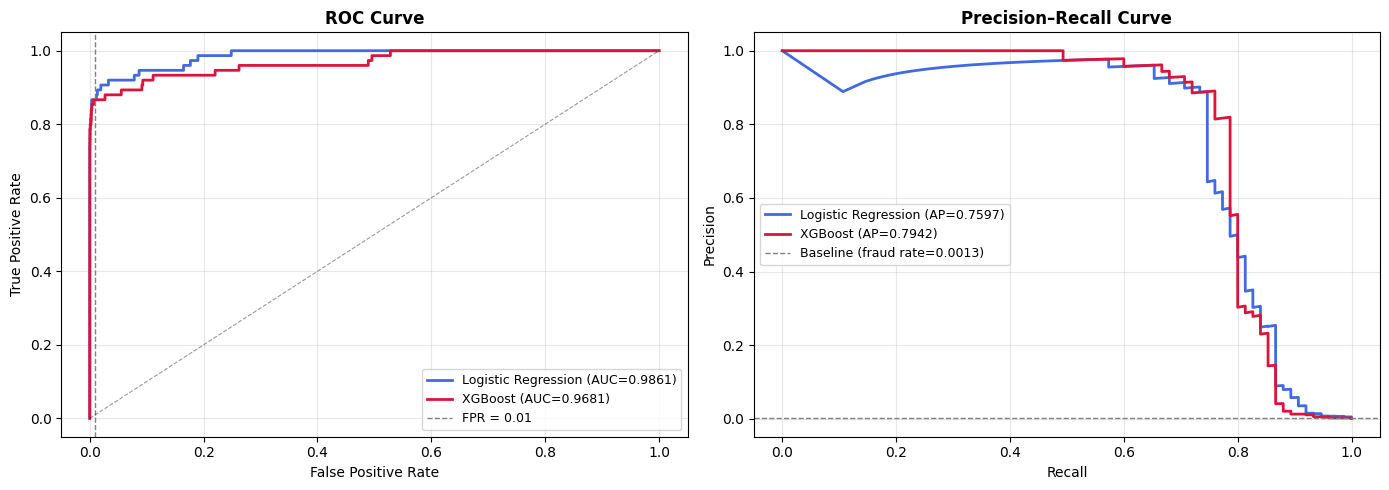

Curves saved to data/processed/roc_pr_curves.png


In [5]:
def recall_at_fpr(y_true, y_proba, target_fpr: float = 0.01):
    """
    Find the probability threshold where FPR ≈ target_fpr,
    and return (recall, precision, threshold) at that operating point.
    """
    fpr_arr, tpr_arr, thresh_arr = roc_curve(y_true, y_proba)
    # Find index where FPR first exceeds target (conservative: pick just below)
    idx = np.searchsorted(fpr_arr, target_fpr, side="right") - 1
    idx = max(0, min(idx, len(thresh_arr) - 1))

    threshold  = thresh_arr[idx]
    recall_val = tpr_arr[idx]
    actual_fpr = fpr_arr[idx]

    # Precision at this threshold
    y_pred_at_t = (y_proba >= threshold).astype(int)
    prec_arr, rec_arr, t_arr = precision_recall_curve(y_true, y_proba)
    # Find matching precision for this recall value (closest)
    rec_idx    = np.argmin(np.abs(rec_arr - recall_val))
    prec_val   = prec_arr[rec_idx]

    return recall_val, prec_val, threshold, actual_fpr


# ── Recall@1%FPR for both models ─────────────────────────────────────────────
TARGET_FPR = 0.01

lr_rec_fpr,  lr_prec_fpr,  lr_thresh,  lr_actual_fpr  = recall_at_fpr(y_te, lr_proba,  TARGET_FPR)
xgb_rec_fpr, xgb_prec_fpr, xgb_thresh, xgb_actual_fpr = recall_at_fpr(y_te, xgb_proba, TARGET_FPR)

print(f"Recall @ {TARGET_FPR*100:.0f}% FPR")
print(f"{'─'*50}")
print(f"{'Model':<25}  {'Recall':>8}  {'Precision':>10}  {'Threshold':>10}  {'Actual FPR':>11}")
print(f"{'─'*50}")
print(f"{'Logistic Regression':<25}  {lr_rec_fpr:>8.4f}  {lr_prec_fpr:>10.4f}  {lr_thresh:>10.4f}  {lr_actual_fpr:>11.4f}")
print(f"{'XGBoost':<25}  {xgb_rec_fpr:>8.4f}  {xgb_prec_fpr:>10.4f}  {xgb_thresh:>10.4f}  {xgb_actual_fpr:>11.4f}")

# ── Plot ROC and PR curves ────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC curves
for label, y_prob, color in [
    ("Logistic Regression", lr_proba,  "royalblue"),
    ("XGBoost",             xgb_proba, "crimson"),
]:
    fp, tp, _ = roc_curve(y_te, y_prob)
    auc = roc_auc_score(y_te, y_prob)
    axes[0].plot(fp, tp, label=f"{label} (AUC={auc:.4f})", color=color, lw=2)

axes[0].axvline(TARGET_FPR, color="gray", linestyle="--", lw=1, label=f"FPR = {TARGET_FPR}")
axes[0].plot([0,1],[0,1], "k--", lw=0.8, alpha=0.4)
axes[0].set_title("ROC Curve", fontweight="bold")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

# PR curves
for label, y_prob, color in [
    ("Logistic Regression", lr_proba,  "royalblue"),
    ("XGBoost",             xgb_proba, "crimson"),
]:
    p, r, _ = precision_recall_curve(y_te, y_prob)
    ap = average_precision_score(y_te, y_prob)
    axes[1].plot(r, p, label=f"{label} (AP={ap:.4f})", color=color, lw=2)

base_rate = y_te.mean()
axes[1].axhline(base_rate, color="gray", linestyle="--", lw=1, label=f"Baseline (fraud rate={base_rate:.4f})")
axes[1].set_title("Precision–Recall Curve", fontweight="bold")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("data/processed/roc_pr_curves.png", dpi=150, bbox_inches="tight")
plt.show()
print("Curves saved to data/processed/roc_pr_curves.png")

## Step 5 — Cost-Based Evaluation

$$\text{Total Cost} = (\text{FN} \times €200) + (\text{FP} \times €5)$$

- **FN × €200** — undetected fraud absorbed by the business  
- **FP × €5** — customer friction cost per wrongly blocked transaction  

The default threshold (0.5) is used for both models. Adjusting the threshold trades FP cost against FN cost — this is explored via the cost-vs-threshold sweep below.

Cost-Based Evaluation (threshold=0.5)
────────────────────────────────────────────────────
Model                         FN      FP   Cost (€)
────────────────────────────────────────────────────
Logistic Regression            7    1159      7,195
XGBoost                       18       8      3,640
────────────────────────────────────────────────────
Savings (LR - XGB): €3,555


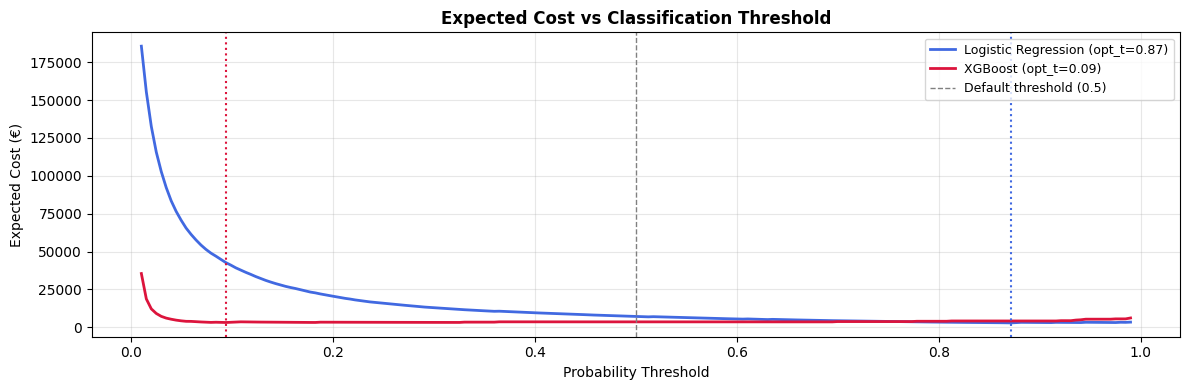


Optimal threshold costs:
  LR  @ t=0.87  → €2,965
  XGB @ t=0.09  → €3,220
Plot saved to data/processed/cost_vs_threshold.png


In [6]:
FRAUD_LOSS   = 200   # € per missed fraud (FN)
FP_COST      = 5     # € per false alarm  (FP)

def compute_cost(y_true, y_pred, fraud_loss=FRAUD_LOSS, fp_cost=FP_COST):
    cm = confusion_matrix(y_true, y_pred)
    tn_, fp_, fn_, tp_ = cm.ravel()
    cost = (fn_ * fraud_loss) + (fp_ * fp_cost)
    return cost, fn_, fp_, tp_, tn_

# ── Cost at default threshold 0.5 ────────────────────────────────────────────
lr_cost,  fn_lr,  fp_lr,  tp_lr,  tn_lr  = compute_cost(y_te, lr_pred)
xgb_cost, fn_xgb, fp_xgb, tp_xgb, tn_xgb = compute_cost(y_te, xgb_pred)

print("Cost-Based Evaluation (threshold=0.5)")
print(f"{'─'*52}")
print(f"{'Model':<25}  {'FN':>5}  {'FP':>6}  {'Cost (€)':>9}")
print(f"{'─'*52}")
print(f"{'Logistic Regression':<25}  {fn_lr:>5}  {fp_lr:>6}  {lr_cost:>9,.0f}")
print(f"{'XGBoost':<25}  {fn_xgb:>5}  {fp_xgb:>6}  {xgb_cost:>9,.0f}")
print(f"{'─'*52}")
print(f"Savings (LR - XGB): €{lr_cost - xgb_cost:,.0f}")

# ── Cost-vs-threshold sweep ───────────────────────────────────────────────────
thresholds = np.linspace(0.01, 0.99, 200)

def cost_curve(y_true, y_proba, thresholds):
    costs = []
    for t in thresholds:
        pred = (y_proba >= t).astype(int)
        c, *_ = compute_cost(y_true, pred)
        costs.append(c)
    return np.array(costs)

lr_costs  = cost_curve(y_te, lr_proba,  thresholds)
xgb_costs = cost_curve(y_te, xgb_proba, thresholds)

lr_opt_t  = thresholds[np.argmin(lr_costs)]
xgb_opt_t = thresholds[np.argmin(xgb_costs)]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(thresholds, lr_costs,  label=f"Logistic Regression (opt_t={lr_opt_t:.2f})",  color="royalblue", lw=2)
ax.plot(thresholds, xgb_costs, label=f"XGBoost (opt_t={xgb_opt_t:.2f})", color="crimson", lw=2)
ax.axvline(0.5, color="gray", linestyle="--", lw=1, label="Default threshold (0.5)")
ax.axvline(lr_opt_t,  color="royalblue", linestyle=":", lw=1.5)
ax.axvline(xgb_opt_t, color="crimson",   linestyle=":", lw=1.5)
ax.set_title("Expected Cost vs Classification Threshold", fontweight="bold")
ax.set_xlabel("Probability Threshold")
ax.set_ylabel("Expected Cost (€)")
ax.legend(fontsize=9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("data/processed/cost_vs_threshold.png", dpi=150, bbox_inches="tight")
plt.show()

# ── Optimal-threshold costs ───────────────────────────────────────────────────
lr_opt_cost,  *_ = compute_cost(y_te, (lr_proba  >= lr_opt_t).astype(int))
xgb_opt_cost, *_ = compute_cost(y_te, (xgb_proba >= xgb_opt_t).astype(int))
print(f"\nOptimal threshold costs:")
print(f"  LR  @ t={lr_opt_t:.2f}  → €{lr_opt_cost:,.0f}")
print(f"  XGB @ t={xgb_opt_t:.2f}  → €{xgb_opt_cost:,.0f}")
print("Plot saved to data/processed/cost_vs_threshold.png")

## Step 6 — Feature Importance & SHAP

**XGBoost gain importance** ranks features by their average contribution to reducing loss across all trees.  
**SHAP (TreeExplainer)** gives each feature a directional attribution for every prediction, providing a more faithful and interpretable picture than gain importance alone.

Top 10 features by XGBoost gain:
   feature  importance
       V14    0.316738
       V10    0.123595
        V4    0.038782
        V8    0.031847
       V20    0.030467
       V12    0.025112
 time_diff    0.021633
       V19    0.020719
log_amount    0.020417
       V21    0.020017


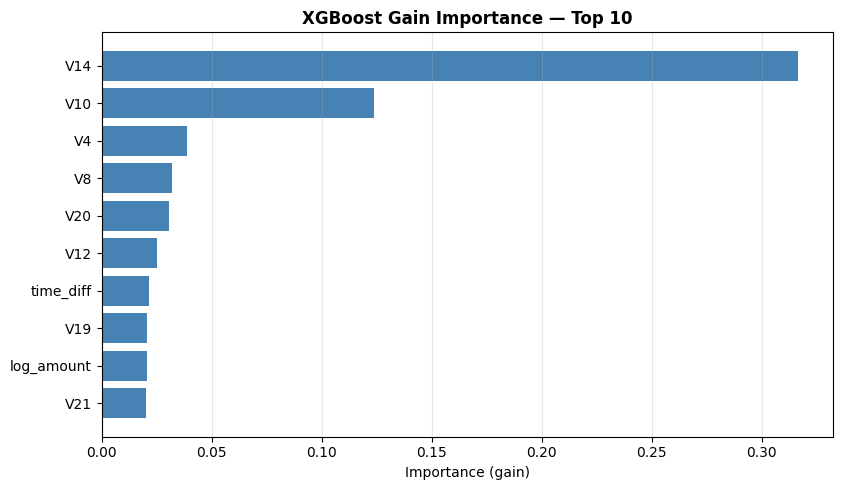

In [7]:
TOP_N = 10   # show top-N features in both plots

# ── XGBoost gain importance ───────────────────────────────────────────────────
imp_df = (
    pd.DataFrame({
        "feature"   : FEATURE_COLS,
        "importance": xgb_model.feature_importances_,
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: XGB gain importance
top_imp = imp_df.head(TOP_N)
axes[0].barh(top_imp["feature"][::-1], top_imp["importance"][::-1], color="steelblue")
axes[0].set_title(f"XGBoost Gain Importance — Top {TOP_N}", fontweight="bold")
axes[0].set_xlabel("Importance (gain)")
axes[0].grid(axis="x", alpha=0.3)

# Right: placeholder labels while SHAP computes (fill in below)
axes[1].set_visible(False)           # will replace with SHAP beeswarm

plt.tight_layout()
print("Top 10 features by XGBoost gain:")
print(imp_df.head(TOP_N).to_string(index=False))

Computing SHAP values on 2,000 samples …
Done.


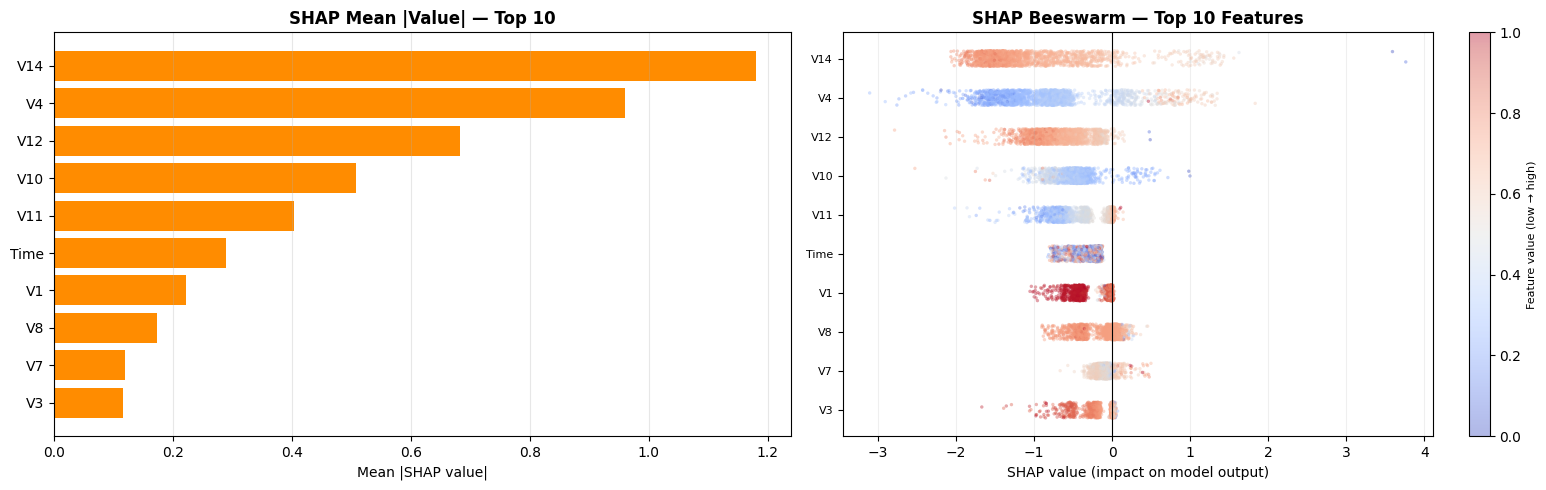

SHAP plots saved to data/processed/shap_summary.png

Top 10 features by mean |SHAP|:
feature  mean_shap
    V14   1.179745
     V4   0.959835
    V12   0.683458
    V10   0.508286
    V11   0.403795
   Time   0.290043
     V1   0.222215
     V8   0.174264
     V7   0.119110
     V3   0.115975


In [8]:
import shap

# ── SHAP TreeExplainer — runs natively on XGBoost, no approximation needed ───
explainer   = shap.TreeExplainer(xgb_model)

# Use a random sample of test set for faster computation (stratified by class)
SHAP_SAMPLE = min(2000, len(X_test_fe))
rng          = np.random.default_rng(42)
fraud_idx    = np.where(y_te == 1)[0]
legit_idx    = np.where(y_te == 0)[0]

# Sample proportionally
n_fraud = min(len(fraud_idx), int(SHAP_SAMPLE * y_te.mean()) + 1)
n_legit = SHAP_SAMPLE - n_fraud
sample_idx = np.concatenate([
    rng.choice(fraud_idx, n_fraud, replace=False),
    rng.choice(legit_idx, n_legit, replace=False),
])

X_shap = X_test_fe.iloc[sample_idx].reset_index(drop=True)

print(f"Computing SHAP values on {len(X_shap):,} samples …")
shap_values = explainer.shap_values(X_shap)
print("Done.")

# ── SHAP bar summary: mean(|SHAP|) per feature ────────────────────────────────
mean_abs_shap = pd.DataFrame({
    "feature"   : FEATURE_COLS,
    "mean_shap" : np.abs(shap_values).mean(axis=0)
}).sort_values("mean_shap", ascending=False).reset_index(drop=True)

top_shap = mean_abs_shap.head(TOP_N)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: mean |SHAP| bar
axes[0].barh(top_shap["feature"][::-1], top_shap["mean_shap"][::-1], color="darkorange")
axes[0].set_title(f"SHAP Mean |Value| — Top {TOP_N}", fontweight="bold")
axes[0].set_xlabel("Mean |SHAP value|")
axes[0].grid(axis="x", alpha=0.3)

# Right: beeswarm / dot plot for top features
top_feat_names = top_shap["feature"].tolist()
top_feat_idx   = [FEATURE_COLS.index(f) for f in top_feat_names]
shap_top       = shap_values[:, top_feat_idx]
X_shap_top     = X_shap[top_feat_names]

# Manually draw dot summary (matplotlib-only, no shap.plots dependency issue)
n_feat = len(top_feat_names)
y_positions = np.arange(n_feat)

for i, feat in enumerate(reversed(top_feat_names)):
    fi = top_feat_names.index(feat)
    sv = shap_top[:, fi]
    fv = X_shap_top[feat].values
    # Normalise feature values for colour mapping
    fv_norm = (fv - fv.min()) / (fv.max() - fv.min() + 1e-9)
    scatter = axes[1].scatter(
        sv, np.full_like(sv, i) + rng.uniform(-0.2, 0.2, len(sv)),
        c=fv_norm, cmap="coolwarm", alpha=0.4, s=6, linewidths=0
    )

axes[1].set_yticks(y_positions)
axes[1].set_yticklabels(list(reversed(top_feat_names)), fontsize=8)
axes[1].axvline(0, color="black", lw=0.8)
axes[1].set_title(f"SHAP Beeswarm — Top {TOP_N} Features", fontweight="bold")
axes[1].set_xlabel("SHAP value (impact on model output)")
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label("Feature value (low → high)", fontsize=8)
axes[1].grid(axis="x", alpha=0.2)

plt.tight_layout()
plt.savefig("data/processed/shap_summary.png", dpi=150, bbox_inches="tight")
plt.show()
print("SHAP plots saved to data/processed/shap_summary.png")

print(f"\nTop {TOP_N} features by mean |SHAP|:")
print(top_shap.to_string(index=False))

## Summary — Model Comparison Table

In [9]:
results = pd.DataFrame({
    "Metric": [
        "ROC-AUC",
        "PR-AUC",
        f"Recall @ {TARGET_FPR*100:.0f}% FPR",
        f"Precision @ {TARGET_FPR*100:.0f}% FPR",
        "F1-score (t=0.5)",
        "Expected Cost €  (t=0.5)",
        "Expected Cost €  (opt t)",
    ],
    "Logistic Regression": [
        f"{lr_roc_auc:.4f}",
        f"{lr_pr_auc:.4f}",
        f"{lr_rec_fpr:.4f}",
        f"{lr_prec_fpr:.4f}",
        f"{f1:.4f}",
        f"€{lr_cost:,.0f}",
        f"€{lr_opt_cost:,.0f}  (t={lr_opt_t:.2f})",
    ],
    "XGBoost": [
        f"{xgb_roc_auc:.4f}",
        f"{xgb_pr_auc:.4f}",
        f"{xgb_rec_fpr:.4f}",
        f"{xgb_prec_fpr:.4f}",
        f"{f1_x:.4f}",
        f"€{xgb_cost:,.0f}",
        f"€{xgb_opt_cost:,.0f}  (t={xgb_opt_t:.2f})",
    ],
})

print("=" * 70)
print(results.to_string(index=False))
print("=" * 70)
print(f"\nCost assumptions:  FN × €{FRAUD_LOSS}  +  FP × €{FP_COST}")
print(f"No SMOTE · No random split · No leakage · No hyperparameter search")
print("\nPhase 3 complete.")

                  Metric Logistic Regression          XGBoost
                 ROC-AUC              0.9861           0.9681
                  PR-AUC              0.7597           0.7942
         Recall @ 1% FPR              0.8667           0.8667
      Precision @ 1% FPR              0.0893           0.0409
        F1-score (t=0.5)              0.1045           0.8143
Expected Cost €  (t=0.5)              €7,195           €3,640
Expected Cost €  (opt t)    €2,965  (t=0.87) €3,220  (t=0.09)

Cost assumptions:  FN × €200  +  FP × €5
No SMOTE · No random split · No leakage · No hyperparameter search

Phase 3 complete.
